In [1]:
import os
import sys

from rdkit import Chem
from rdkit.Chem import AllChem

import numpy as np
import pandas as pd
import pickle as pk
import torch

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.chdir('/afs/csail.mit.edu/u/s/samsl/Work/Adapting_PLM_DTI')
DATA_DIR = '/afs/csail.mit.edu/u/s/samsl/Work/databases/QSAR-Grisoni/'

In [3]:
from src.featurizers import MorganFeaturizer, ProtBertFeaturizer
from src.architectures import SimpleCoembedding

# Load model
device = torch.device(6)
drug_f = MorganFeaturizer().cuda(device)
target_f = ProtBertFeaturizer().cuda(device)
model = SimpleCoembedding(drug_f.shape, target_f.shape, 1024)
model.load_state_dict(torch.load("best_models/ProdModels/prod_within_state.pt"))
model = model.to(device)

## Load Data

In [4]:
df = pd.read_csv(f'{DATA_DIR}/Grisoni_et_al_2016_EnvInt88.csv')
df = df.drop(['CAS','Set'],axis=1).set_index('SMILES')

In [39]:
df.head()

,nHM,piPC09,PCD,X2Av,MLOGP,ON1V,N-072,B02[C-N],F04[C-O],Class,logBCF
SMILES,,,,,,,,,,,
O=[N+](c1ccc(cc1)O)[O-],0,0.0,1.49,0.14,1.35,0.72,0,1,5,1,0.74
O=[N+](c1ccc(cc1)OC)[O-],0,0.0,1.47,0.14,1.70,0.88,0,1,5,1,0.93
c1cc(ccc1C(C)C)C(C)C,0,0.0,1.20,0.25,4.14,2.06,0,0,0,3,3.24
O=[N+]([O-])c1ccc(cc1)[N+](=O)[O-],0,0.0,1.69,0.13,1.89,0.79,0,1,8,3,-0.40
C=CC1CCC=CC1,0,0.0,0.52,0.25,2.65,1.31,0,0,0,1,2.24


In [29]:
for c in df.columns:
    print(c,len(df[c].value_counts()))

nHM 11
piPC09 322
PCD 224
X2Av 63
MLOGP 346
ON1V 261
N-072 4
B02[C-N] 2
F04[C-O] 23
Class 3
logBCF 391


## Generate Projections

In [6]:
smile_projections = {}
smile_morgans = {}

for smi in tqdm(df.index,total=len(df)):
    morg = drug_f(smi)
    smile_projections[smi] = model.drug_projector(morg.unsqueeze(0)).detach().cpu().numpy().squeeze()
    smile_morgans[smi] = morg.cpu().numpy().squeeze()
    
smile_projections_np = np.stack(list(smile_projections.values()))
smile_morgans_np = np.stack(list(smile_morgans.values()))

  0%|          | 0/779 [00:00<?, ?it/s]

In [7]:
from scipy.stats import pearsonr, spearmanr

In [40]:
bcf_distance = np.abs(np.subtract.outer(df['logBCF'].values, df['logBCF'].values))

In [8]:
corr, pval = spearmanr(df.values,axis=1)

In [9]:
corrdf = pd.DataFrame(corr,index=df.index,columns=df.index)

In [21]:
proj_corr, proj_p = spearmanr(smile_projections_np,axis=1)
proj_corrdf = pd.DataFrame(proj_corr,index=df.index,columns=df.index)

morg_corr, proj_p = spearmanr(smile_morgans_np,axis=1)
morg_corrdf = pd.DataFrame(morg_corr,index=df.index,columns=df.index)

In [52]:
tox_tril = corrdf.values[np.tril_indices(corrdf.shape[0])]
bcf_distance_tril = bcf_distance[np.tril_indices(bcf_distance.shape[0])]
proj_tril = proj_corrdf.values[np.tril_indices(proj_corrdf.shape[0])]
morg_tril = morg_corrdf.values[np.tril_indices(morg_corrdf.shape[0])]

In [100]:
from itertools import combinations
from torch.nn import CosineSimilarity

def cosine_similarity(x,y):
    cs = CosineSimilarity(dim=0)
    return cs(torch.from_numpy(x), torch.from_numpy(y)).detach().cpu().item()

var = 'logBCF'

arr_bcf = []
arr_ours = []
arr_morgan = []

n = 303031
for (i,j) in tqdm(list(combinations(df.index,2))[:n],total=n):
    arr_bcf.append(np.abs(df.loc[i,var] - df.loc[j,var]))
    arr_ours.append(1 - cosine_similarity(smile_projections[i],smile_projections[j]))
    arr_morgan.append(1 - cosine_similarity(smile_morgans[i],smile_morgans[j]))

  0%|          | 0/303031 [00:00<?, ?it/s]

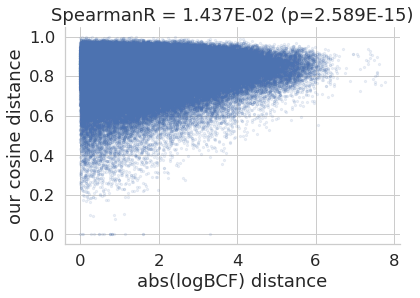

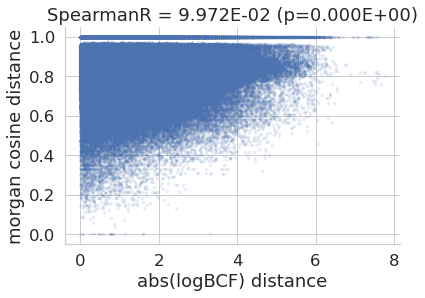

In [105]:
our_r, our_p = spearmanr(arr_bcf, arr_ours)
morg_r, morg_p = spearmanr(arr_bcf, arr_morgan)
    
plt.scatter(arr_bcf, arr_ours, s = 5, alpha=0.1)
plt.xlabel('abs(logBCF) distance')
plt.ylabel('our cosine distance')
plt.title(f'SpearmanR = {our_r:.3E} (p={our_p:.3E})')
sns.despine()
plt.show()

plt.scatter(arr_bcf, arr_morgan, s = 5, alpha=0.1)
plt.xlabel('abs(logBCF) distance')
plt.ylabel('morgan cosine distance')
plt.title(f'SpearmanR = {morg_r:.3E} (p={morg_p:.3E})')
sns.despine()
plt.show()

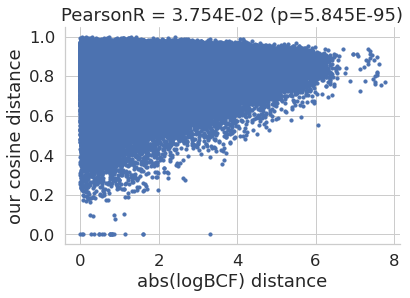

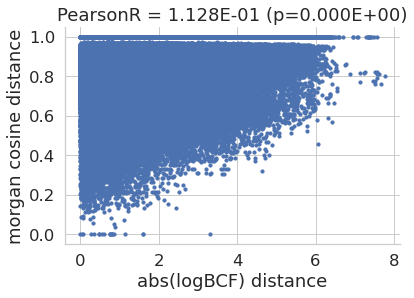

In [102]:
our_r, our_p = pearsonr(arr_bcf, arr_ours)
morg_r, morg_p = pearsonr(arr_bcf, arr_morgan)
    
plt.scatter(arr_bcf, arr_ours, s = 10)
plt.xlabel('abs(logBCF) distance')
plt.ylabel('our cosine distance')
plt.title(f'PearsonR = {our_r:.3E} (p={our_p:.3E})')
sns.despine()
plt.show()

plt.scatter(arr_bcf, arr_morgan, s = 10)
plt.xlabel('abs(logBCF) distance')
plt.ylabel('morgan cosine distance')
plt.title(f'PearsonR = {morg_r:.3E} (p={morg_p:.3E})')
sns.despine()
plt.show()

In [182]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [183]:
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

data_tsne = TSNE(
    metric="cosine"
).fit_transform(smile_projections_np)

/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


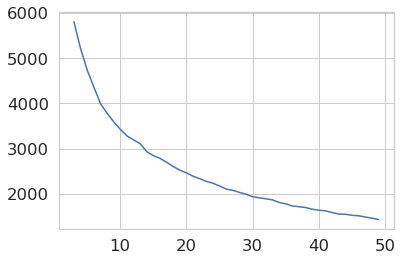

In [184]:
sscaler = StandardScaler()
toxprofile_scaled = sscaler.fit_transform(df.values)

ks = np.arange(3,50,1)
scores = []
inertia = []
for k_clust in ks:
    
    kmclustering = KMeans(n_clusters=k_clust)
    km_clusters = kmclustering.fit_predict(toxprofile_scaled)
    scores.append(silhouette_score(toxprofile_scaled, km_clusters))
    inertia.append(kmclustering.inertia_)
    
plt.plot(ks,inertia)
plt.show()

In [186]:
kmclustering = KMeans(n_clusters=15)
km_clusters = kmclustering.fit_predict(toxprofile_scaled)
print(silhouette_score(toxprofile_scaled, km_clusters), silhouette_score(smile_projections_np, km_clusters), silhouette_score(smile_morgans_np, km_clusters))

0.21365104017368827 -0.06388259 -0.05823606


In [187]:
set(km_clusters)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

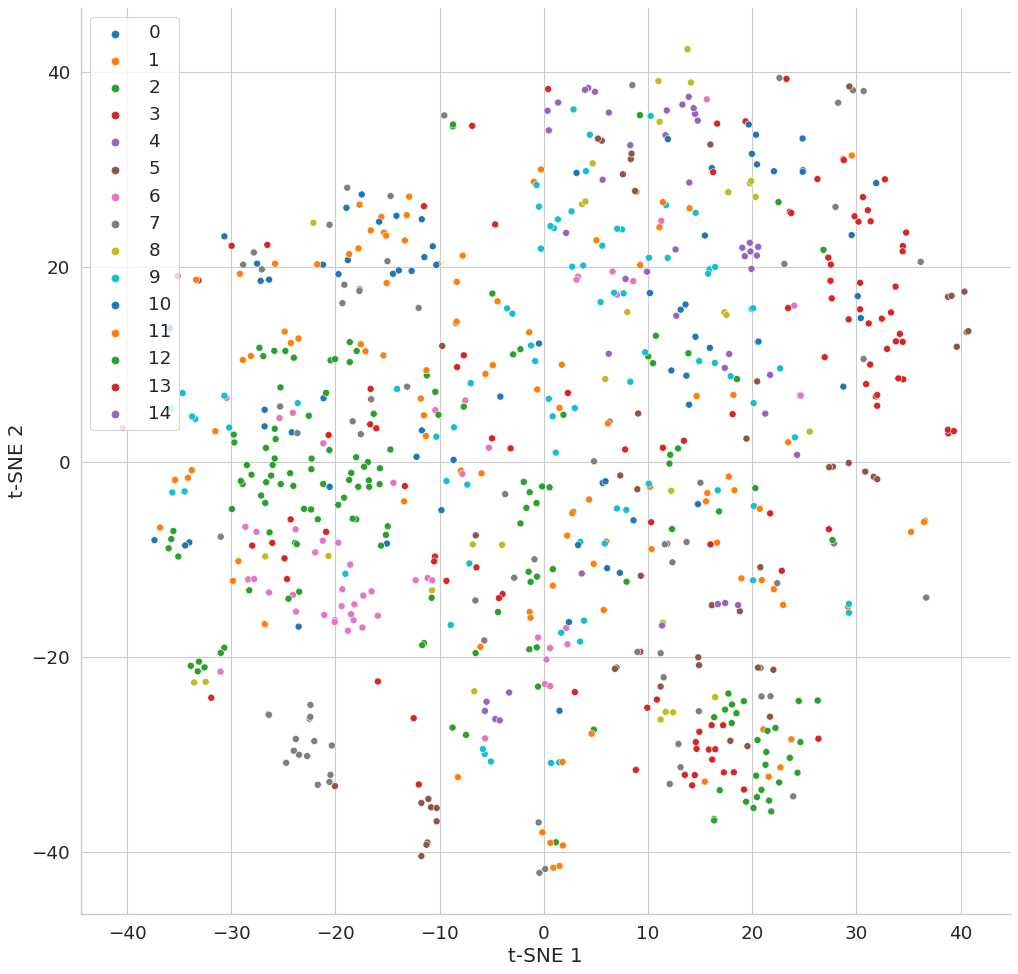

In [188]:
sns.set(style='whitegrid',font_scale=1.5)
plt.figure(figsize=(15, 15), dpi=80)

style = km_clusters

plot_df = pd.DataFrame({
    't-SNE 1': data_tsne[:,0],
    't-SNE 2': data_tsne[:,1],
    'Class': style
})

sns.scatterplot(
    data = plot_df,
    x = "t-SNE 1",
    y = "t-SNE 2",
    hue = 'Class',
    s = 40,
    palette = 'tab10'
)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
# plt.title('Projection of Surfaceome Proteins into DTI Space')
plt.legend()
sns.despine()
plt.show()

## Combinations

In [90]:
from scipy.special import comb
from itertools import combinations
from torch.nn import CosineSimilarity

cosine_similarity = CosineSimilarity(dim=0)

In [91]:
results = {}

for (a,b) in tqdm(combinations(df.index,2),total=int(comb(len(df),2))):
    tox_corr = corrdf.loc[a,b]
    our_dist = cosine_similarity(torch.from_numpy(smile_projections[a]), torch.from_numpy(smile_projections[b])).detach().cpu().item()
    morg_dist = cosine_similarity(torch.from_numpy(smile_morgans[a]), torch.from_numpy(smile_morgans[b])).detach().cpu().item()
    results[(a,b)] = (tox_corr, our_dist, morg_dist)

  0%|          | 0/303031 [00:00<?, ?it/s]

In [92]:
resDf = pd.DataFrame(results).T
resDf.columns = ['ToxCorr','OurSim', 'MorganSim']

In [93]:
resDf

ToxCorr  \
O=[N+](c1ccc(cc1)O)[O-]                 O=[N+](c1ccc(cc1)OC)[O-]            0.990698   
                                        c1cc(ccc1C(C)C)C(C)C                0.366505   
                                        O=[N+]([O-])c1ccc(cc1)[N+](=O)[O-]  0.812067   
                                        C=CC1CCC=CC1                        0.342392   
                                        C=Cc1ccccc1                         0.453308   
...                                                                              ...   
FC(F)(F)c2cc(ccc2(N=C(n1cncc1)COCCC))Cl CC(c1ccc(cc1)O)CC                   0.349727   
                                        O=[N+](c1ccc(cc1)C)[O-]             0.412460   
O=[N+]([O-])c1cccc(c1)[N+](=O)[O-]      CC(c1ccc(cc1)O)CC                   0.595335   
                                        O=[N+](c1ccc(cc1)C)[O-]             1.000000   
CC(c1ccc(cc1)O)CC                       O=[N+](c1ccc(cc1)C)[O-]             0.595335   

                                                                              OurSim  \
O=[N+](c1ccc(cc1)O)[O-]                 O=[N+](c1ccc(cc1)OC)[O-]            0.562246   
                                        c1cc(ccc1C(C)C)C(C)C                0.188316   
                                        O=[N+]([O-])c1ccc(cc1)[N+](=O)[O-]  0.747090   
                                        C=CC1CCC=CC1                        0.109773   
                                        C=Cc1ccccc1                         0.231805   
...                                                                              ...   
FC(F)(F)c2cc(ccc2(N=C(n1cncc1)COCCC))Cl CC(c1ccc(cc1)O)CC                   0.180874   
                                        O=[N+](c1ccc(cc1)C)[O-]             0.147201   
O=[N+]([O-])c1cccc(c1)[N+](=O)[O-]      CC(c1ccc(cc1)O)CC                   0.134005   
                                        O=[N+](c1ccc(cc1)C)[O-]             0.496971   
CC(c1ccc(cc1)O)CC                       O=[N+](c1ccc(cc1)C)[O-]             0.195703   

                                                                            MorganSim  
O=[N+](c1ccc(cc1)O)[O-]                 O=[N+](c1ccc(cc1)OC)[O-]             0.668648  
                                        c1cc(ccc1C(C)C)C(C)C                 0.213201  
                                        O=[N+]([O-])c1ccc(cc1)[N+](=O)[O-]   0.849837  
                                        C=CC1CCC=CC1                         0.054074  
                                        C=Cc1ccccc1                          0.188982  
...                                                                               ...  
FC(F)(F)c2cc(ccc2(N=C(n1cncc1)COCCC))Cl CC(c1ccc(cc1)O)CC                    0.221359  
                                        O=[N+](c1ccc(cc1)C)[O-]              0.166667  
O=[N+]([O-])c1cccc(c1)[N+](=O)[O-]      CC(c1ccc(cc1)O)CC                    0.162698  
                                        O=[N+](c1ccc(cc1)C)[O-]              0.628828  
CC(c1ccc(cc1)O)CC                       O=[N+](c1ccc(cc1)C)[O-]              0.210819  

[303031 rows x 3 columns]

0.24849996489144524 0.0


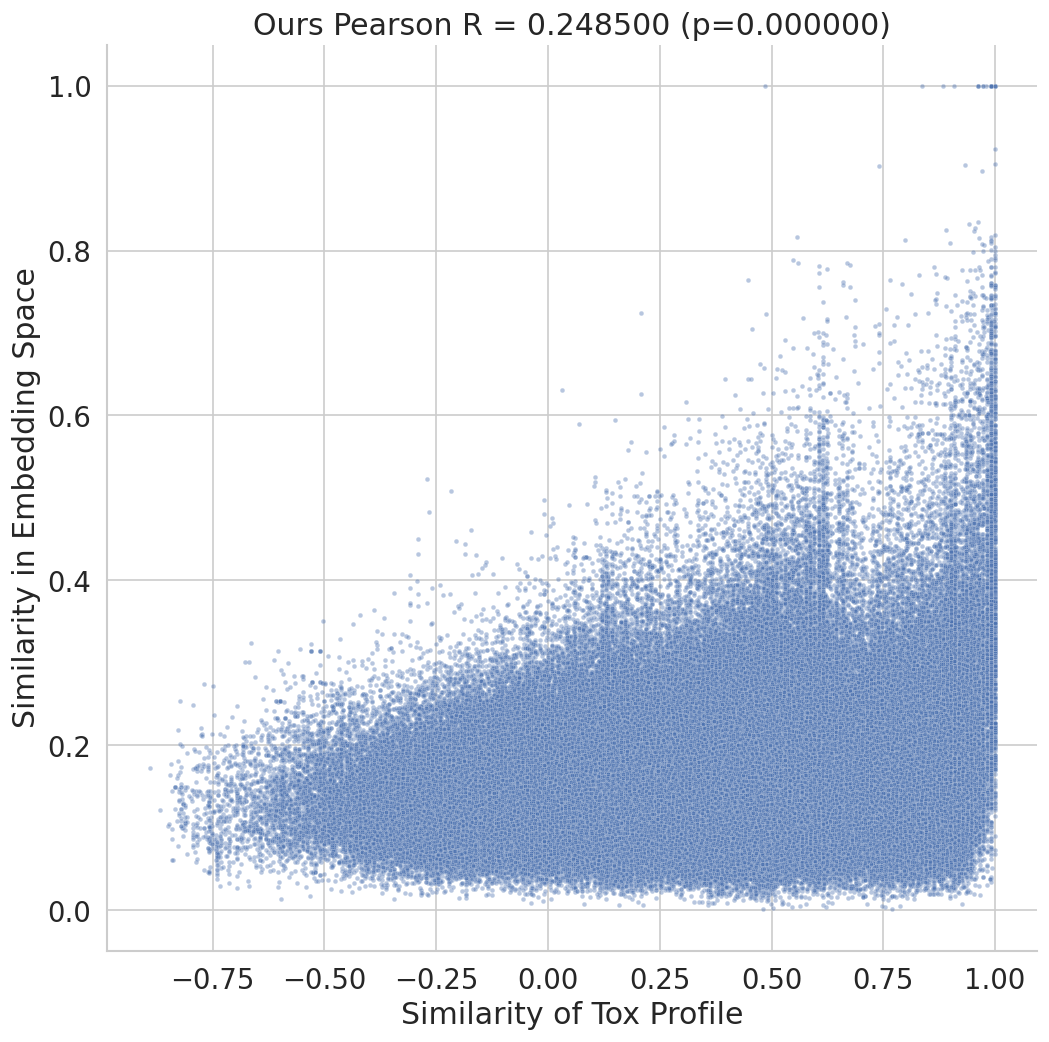

0.3976958628559093 0.0


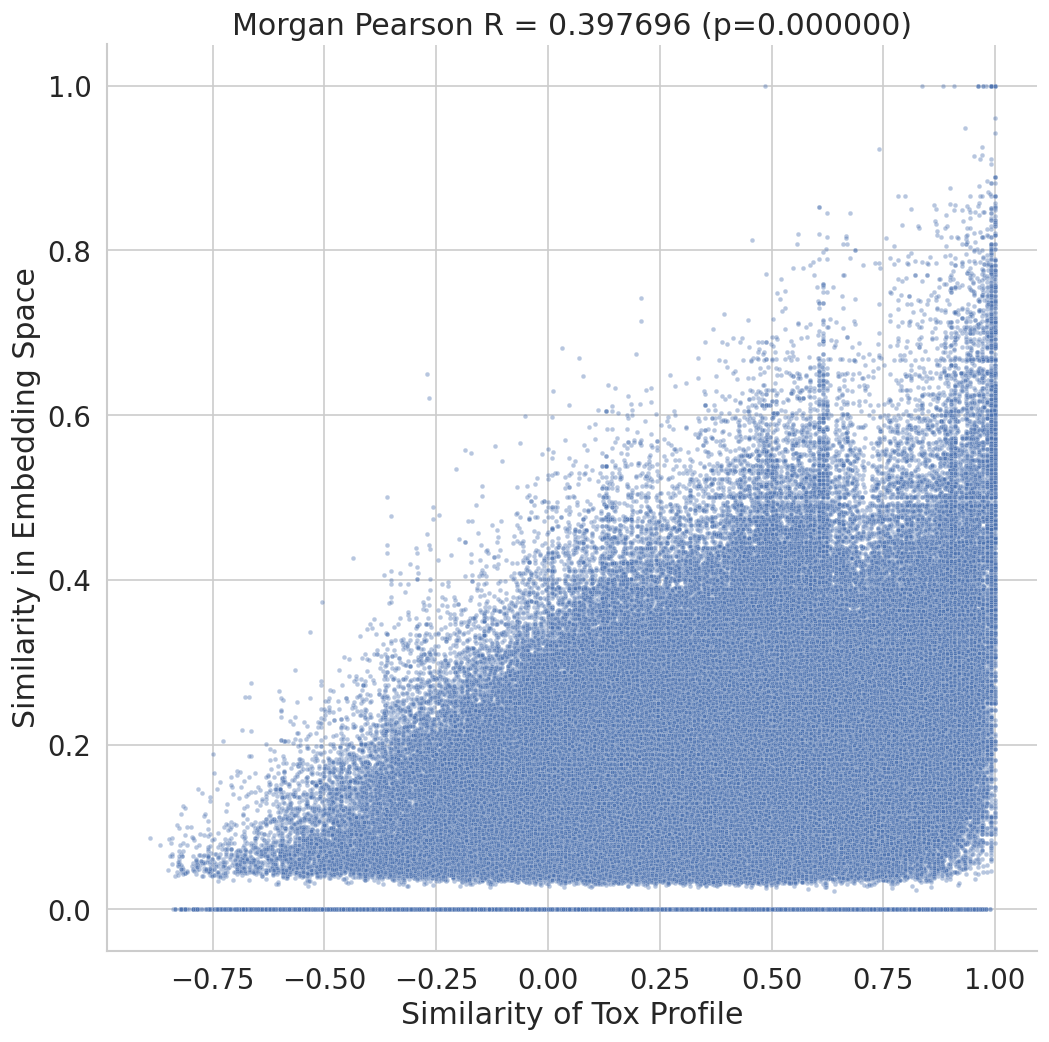

In [94]:
prs_r, prs_p = pearsonr(resDf['ToxCorr'], resDf['OurSim'])
print(prs_r, prs_p)

plt.figure(figsize=(10, 10), dpi=120)
sns.set(style='whitegrid',font_scale=1.5)

sns.scatterplot(data=resDf,
                x='ToxCorr',
                y='OurSim',
                s=8,
                alpha=0.4
               )
plt.xlabel('Similarity of Tox Profile')
plt.ylabel('Similarity in Embedding Space')
plt.title(f'Ours Pearson R = {prs_r:3f} (p={prs_p:3f})')
sns.despine()
plt.show()

prs_r, prs_p = pearsonr(resDf['ToxCorr'], resDf['MorganSim'])
print(prs_r, prs_p)

plt.figure(figsize=(10, 10), dpi=120)
sns.set(style='whitegrid',font_scale=1.5)

sns.scatterplot(data=resDf,
                x='ToxCorr',
                y='MorganSim',
                s=8,
                alpha=0.4
               )
plt.xlabel('Similarity of Tox Profile')
plt.ylabel('Similarity in Embedding Space')
plt.title(f'Morgan Pearson R = {prs_r:3f} (p={prs_p:3f})')
sns.despine()
plt.show()